In [1]:
# code for loading the format for the notebook
import os

# path : store the current path to convert back to it later
path = os.getcwd()
os.chdir( os.path.join('..', 'notebook_format') )
from formats import load_style
load_style(css_style = 'custom2.css')

In [2]:
os.chdir(path)
%matplotlib inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = 8, 6 # change default figure size
plt.rcParams['font.size'] = 12 # and font size

# 1. magic to print version
# 2. magic so that the notebook will reload external python modules
%load_ext watermark
%load_ext autoreload 
%autoreload 2

# if you get a deprecation warning, 
# it is coming from XGBClassifier, since it's still using
# from sklearn.cross_validation import RandomizedSearchCV
# instead of the preferable new api
# from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import roc_auc_score
from xgboost.sklearn import XGBClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split
from sklearn.model_selection import RandomizedSearchCV

%watermark -a 'Ethen' -d -t -v -p numpy,pandas,matplotlib,xgboost,scikit-learn

Ethen 2016-12-08 13:26:10 

CPython 3.5.2
IPython 4.2.0

numpy 1.11.2
pandas 0.18.1
matplotlib 1.5.1
xgboost 0.6
scikit-learn 0.18


/Users/ethen/anaconda/lib/python3.5/site-packages/sklearn/cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


# XGBoost

## Preparation <a name='preparation' />

For installing xgboost on mac: 

```bash
# install gcc from brew, 
# note that the second command can 
# take up to 30 minutes, be patient
brew tap homebrew/versions
brew install gcc --without-multilib

# install xgboost
git clone --recursive https://github.com/dmlc/xgboost 
cd xgboost
cp make/minimum.mk ./config.mk
make -j4

cd python-package 
sudo python setup.py install

```

In this toy example, we will be dealing with a **binary classification** task. We start off by generating a 20 dimensional artificial dataset with 1000 samples, where 8 features holding information, 3 are redundant and 2 repeated. And perform a train/test split. The testing data will be useful for validating the performance of our algorithms.

In [3]:
seed = 104
X, y = make_classification( n_samples = 1000, n_features = 20, 
                            n_informative = 8, n_redundant = 3, 
                            n_repeated = 2, random_state = seed )

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = seed)

# confirm that the dataset is balanced,
# that is the target variable is equally 
# distributed across both dataset
print('Train label distribution:')
print(np.bincount(y_train))

print('\nTest label distribution:')
print(np.bincount(y_test))

Train label distribution:
[395 405]

Test label distribution:
[104  96]


In [4]:
# we can establish a decision tree classifier as a baseline,
# and see if a more complex model will beat it
tree = DecisionTreeClassifier(random_state = seed, max_depth = 6)

# train classifier
tree.fit(X_train, y_train)

# predict output
tree_y_pred = tree.predict(X_test)
tree_y_pred_prob = tree.predict_proba(X_test)[:, 1]

# evaluation
tree_auc = roc_auc_score(y_test, tree_y_pred_prob)
print('auc:', tree_auc)

auc: 0.828475560897


## XGBoost Basics

We start by training a xgboost model using a fix set of parameters. For further details of the parameter (using scikit-learn like API) refer to the [XGBoost Documentation: Python API documentation](http://xgboost.readthedocs.io/en/latest/python/python_api.html#module-xgboost.sklearn). 

In [5]:
xgb_params_fixed = {
    'learning_rate': 0.1,
    
    # use 'multi:softprob' for multi-class problems
    'objective': 'binary:logistic',
    
    # length of the longest path from a root to a leaf
    'max_depth': 6,
    
    # subsample ratio of columns when constructing each tree
    'colsample_bytree': 0.8,
    
    # setting it to a positive value 
    # might help when class is extremely imbalanced
    # as it makes the update more conservative
    'max_delta_step': 1, 
    'n_estimators': 150,
    
    # use all possible cores for training
    'nthread': -1
}
model_xgb = XGBClassifier(**xgb_params_fixed)

# we also specify the evaluation dataset and metric
# to record the model's performance history, note that
# we can supply multiple evaluation metric by passig a 
# list to `eval_metric`
eval_set = [ (X_train, y_train), (X_test, y_test) ]
model_xgb.fit(X_train, y_train, eval_metric = 'auc', eval_set = eval_set, verbose = False)

XGBClassifier(base_score=0.5, colsample_bylevel=1, colsample_bytree=0.8,
       gamma=0, learning_rate=0.1, max_delta_step=1, max_depth=6,
       min_child_weight=1, missing=None, n_estimators=150, nthread=-1,
       objective='binary:logistic', reg_alpha=0, reg_lambda=1,
       scale_pos_weight=1, seed=0, silent=True, subsample=1)

We can retrieve the performance of the model on the evaluation dataset and plot it to get insight into the training process. The `evals_results_` dictionary stores the `validation_0` and `validation_1` as its first key. This corresponds to the order that datasets were provided to the `eval_set` argument. The second key is the `eval_metric` that were provided.

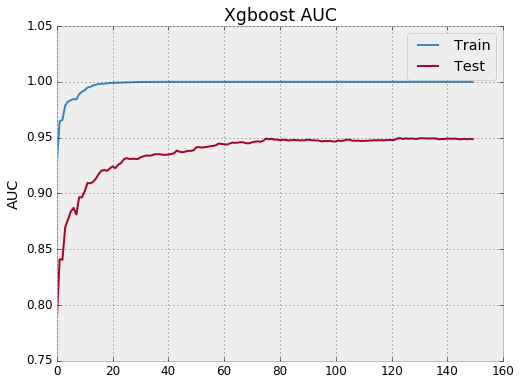

In [6]:
history = model_xgb.evals_result_

x_axis = range( len(history['validation_0']['auc']) )
plt.plot( x_axis, history['validation_0']['auc'], label = 'Train' )
plt.plot( x_axis, history['validation_1']['auc'], label = 'Test' )
plt.legend(loc = 'best')
plt.ylabel('AUC')
plt.title('Xgboost AUC')
plt.show()

From reviewing the plot, it looks like there is an opportunity to stop the learning early, since the auc score for the testing dataset stopped increasing around 80 estimators. Luckily, xgboost supports this functionality.

Early stopping works by monitoring the performance of the model that is being trained on a separate validation or test dataset and stopping the training procedure once the performance on the validation or test dataset has not improved after a fixed number of training iterations (we can specify the number). This will potentially save us a lot of time from training a model that does not improve its performance over time.

The evaluation measure may be the loss function that is being optimized to train the model (such as logarithmic loss), or an external metric of interest to the problem in general (such as the auc score that we've used above). The full list of performace measure that we can directly specify can be found at the `eval_metric` section of the [XGBoost Doc: Learning Task Parameters](http://xgboost.readthedocs.io/en/latest//parameter.html#learning-task-parameters).

In addition to specifying a evaluation metric and dataset, to use early stopping we also need to specify the `early_stopping_rounds`. This is essentially telling the model to stop the training process if the evaluation dataset's evaluation metric does not improve over this many rounds. Note that if multiple evaluation datasets or multiple evaluation metrics are provided in a list, then early stopping will use the last one in the list.

For example, we can check for no improvement in auc over the 10 rounds as follows:

In [7]:
# we set verbose to 10 so that it will print out the evaluation metric for the
# evaluation dataset for every 10 round
model_xgb.fit( X_train, y_train, 
               eval_metric = 'auc', eval_set = eval_set,
               early_stopping_rounds = 5, verbose = 10 )

# we can then access the best number of tree and use it later for prediction
print('best iteration', model_xgb.best_ntree_limit)

[0]	validation_0-auc:0.925979	validation_1-auc:0.785707
Multiple eval metrics have been passed: 'validation_1-auc' will be used for early stopping.

Will train until validation_1-auc hasn't improved in 5 rounds.
[10]	validation_0-auc:0.992368	validation_1-auc:0.901993
[20]	validation_0-auc:0.999075	validation_1-auc:0.924179
[30]	validation_0-auc:0.999837	validation_1-auc:0.932292
[40]	validation_0-auc:0.999981	validation_1-auc:0.934796
Stopping. Best iteration:
[35]	validation_0-auc:0.99995	validation_1-auc:0.935096

best iteration 36


Keep in mind that XGBoost will return the model from the last iteration, not the best one. Hence when making the prediction, we need to pass the `ntree_limit` parameter to ensure that we get the optimal model's prediction.

In [8]:
# print the model's performance
ntree_limit = model_xgb.best_ntree_limit
y_pred_prob = model_xgb.predict_proba( X_test, ntree_limit = ntree_limit )[:, 1]
print('auc:', roc_auc_score(y_test, y_pred_prob) )

auc: 0.935096153846


In [9]:
# we can also access the feature importance and visualize it
importances = model_xgb.feature_importances_

# give a name for each feature, here it is 'f' + the feature column number 
features = [ 'f' + str(imp) for imp in np.arange(len(importances)) ]

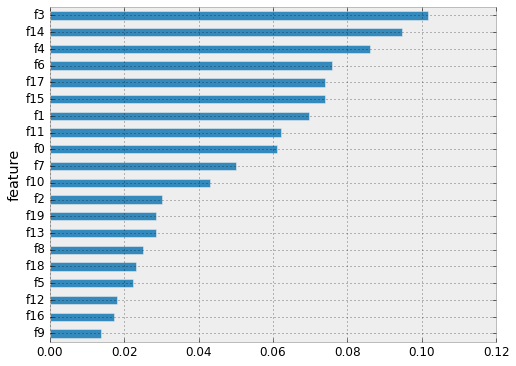

In [10]:
# create df
importances_df = pd.DataFrame({
    'importances': importances,
    'feature': features
}).sort_values(by = 'importances')

importances_df.plot(kind = 'barh', x = 'feature', y = 'importances', legend = False)
plt.show()

Side note: Apart from using the built-in evaluation metric, we can also define one ourselves. The evaluation metric should be a function that takes two argument y_pred, y_true (it doesn't have to named like this). It is assumed that y_true will be a DMatrix object so that we can call the `get_label` method to access the true labels. As for the return value, the function ust return a str, value pair where the str is a name for the evaluation metric and value is the value of the evaluation. This objective is always minimized.

In [11]:
def misclassified(y_pred, y_true):
    """
    custom evaluation metric for xgboost, the metric
    counts the number of misclassified examples assuming 
    that classes with p>0.5 are positive
    """
    labels = y_true.get_label() # obtain true labels
    preds  = y_pred > 0.5 # obtain predicted values
    return 'misclassified', np.sum(labels != preds)

model_xgb.fit( X_train, y_train, 
               eval_metric = misclassified, eval_set = eval_set,
               early_stopping_rounds = 5, verbose = 10 )

ntree_limit = model_xgb.best_ntree_limit
y_pred_prob = model_xgb.predict_proba(X_test, ntree_limit = ntree_limit)[:, 1]
print('auc:', roc_auc_score(y_test, y_pred_prob) )

[0]	validation_0-misclassified:83	validation_1-misclassified:48
Multiple eval metrics have been passed: 'validation_1-misclassified' will be used for early stopping.

Will train until validation_1-misclassified hasn't improved in 5 rounds.
[10]	validation_0-misclassified:32	validation_1-misclassified:33
[20]	validation_0-misclassified:12	validation_1-misclassified:30
Stopping. Best iteration:
[15]	validation_0-misclassified:20	validation_1-misclassified:28

auc: 0.91741786859


## Hyperparamter Tuning (Random Search)

Next, since overfitting is a common problem with sophisticated algorithms like gradient boosting, we'll introduce ways to tune the model's hyperparameter and deal with them. If a xgboost model is too complex we can try:

- Reduce `max_depth`, the depth of each tree.
- Increase `min_child_weight`, minimum sum of obervation's weight needed in a child (think of it as the number of observation's needed in a tree's node).
- Increase `gamma`, the minimum loss reduction required to make a further partition.
- Increase regularization parameters, `reg_lambda` (l2 regularization) and `reg_alpha` (l1 regularization).
- Add more randomness by using `subsample` (the fraction of observations to be randomly samples for fitting each tree), `colsample_bytree` (the fraction of columns to be randomly samples for fitting each tree) parameters.

We'll use a [`Random Search`](http://scikit-learn.org/stable/modules/grid_search.html#randomized-parameter-optimization) to tune the model's hyperparameter.

In [12]:
# For each parameter, either a distribution over possible values 
# (the scipy.stats module contains many useful distributions)
# or a list of discrete choices (which will be sampled uniformly) can be specified
xgb_params_opt = {
    'max_depth': [3, 6, 10],
    'colsample_bytree': [0.7, 0.8, 0.9],
    'subsample': [0.7, 0.8, 0.9] 
}

# additional parameters to pass to fit
xgb_fit_params = {   
    'eval_metric': 'auc', 
    'eval_set': eval_set,
    'early_stopping_rounds': 5,
    'verbose': False
}

rs_xgb = RandomizedSearchCV(
    estimator = model_xgb,
    param_distributions = xgb_params_opt,
    fit_params = xgb_fit_params,
    scoring = 'roc_auc',
    
    # stratified kfold
    cv = 10,
    
    # number of parameter settings that are sampled
    n_iter = 5,
    n_jobs = -1,
    verbose = 1
)
rs_xgb.fit(X_train, y_train)

print( 'Best auc obtained: {0}'.format(rs_xgb.best_score_) )
print('Parameters:')
for key, value in rs_xgb.best_params_.items():
    print( '\t{}: {}'.format( key, value ) )

Fitting 10 folds for each of 5 candidates, totalling 50 fits
Best auc obtained: 0.9476422177923702
Parameters:
	max_depth: 10
	subsample: 0.9
	colsample_bytree: 0.9


[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:    0.8s finished


In [13]:
ntree_limit = rs_xgb.best_estimator_.best_ntree_limit
y_pred_prob = rs_xgb.best_estimator_.predict_proba(X_test, ntree_limit = ntree_limit )[ :, 1 ]
print( 'auc:', roc_auc_score(y_test, y_pred_prob) )

auc: 0.941306089744


## Reference

- [XGBoost Documentation: Installing Guide](https://github.com/dmlc/xgboost/blob/master/doc/build.md)
- [XGBoost Documentation: Python API documentation](http://xgboost.readthedocs.io/en/latest/python/python_api.html#module-xgboost.sklearn)
- [XGBoost Documentation: Learning Task Parameters](http://xgboost.readthedocs.io/en/latest//parameter.html#learning-task-parameters)
- [Blog: Installing XGBoost on Mac OSX](https://www.ibm.com/developerworks/community/blogs/jfp/entry/Installing_XGBoost_on_Mac_OSX?lang=en)
- [Online Course: practical xgboost in python](http://education.parrotprediction.teachable.com/courses/practical-xgboost-in-python)
- [Analytics Vidhya: Complete Guide to Parameter Tuning in XGBoost](https://www.analyticsvidhya.com/blog/2016/03/complete-guide-parameter-tuning-xgboost-with-codes-python/)
- [Blog: Avoid Overfitting By Early Stopping With XGBoost In Python](http://machinelearningmastery.com/avoid-overfitting-by-early-stopping-with-xgboost-in-python/)